# imports

In [63]:
import os
import matplotlib.ticker as ticker
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm, trange
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# KDE Plots for Age and Time Distribution

The following plots visualize the distribution of age and time in the synthetic dataset using Kernel Density Estimation (KDE). The age distribution plot shows the probability density of ages within predefined age groups, emphasizing smoother transitions between age ranges. The time distribution plot highlights the density of occurrences throughout the day (0–24 hours), reflecting the likelihood of events during specific hours. The KDE plots provide a clear and continuous representation of the data's underlying probability distributions.

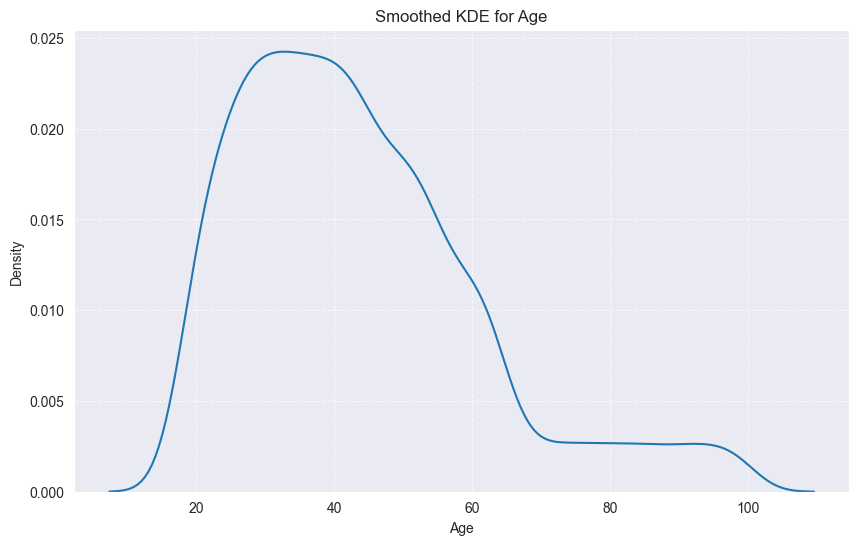

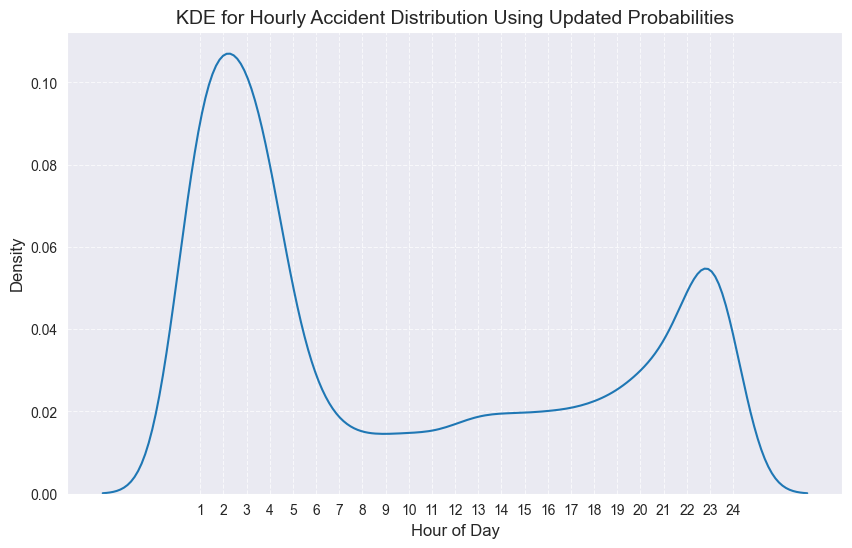

In [64]:
# Constants
NUM_ROWS = 300000

# Age distributions
age_groups = {
    '17-18': (17, 18, 0.0035),
    '19-24': (19, 24, 0.0565),
    '25-34': (25, 34, 0.1274),
    '35-44': (35, 44, 0.1265),
    '45-54': (45, 54, 0.0983),
    '55-64': (55, 64, 0.0638),
    '65+': (65, 100, 0.0504)
}

# Generate synthetic data for Age
age_data = []
for group, (min_age, max_age, prob) in age_groups.items():
    count = int(prob * NUM_ROWS)
    age_data.extend(np.random.randint(min_age, max_age + 1, size=count))

# === Updated Time Generation ===
# Updated probabilities for hourly accident distribution
hours = list(range(24))
normalized_scaled_array = [
    0.0950, 0.1154, 0.1248, 0.1047, 0.0564, 0.0275, 0.0177, 0.0152,
    0.0139, 0.0142, 0.0144, 0.0164, 0.0185, 0.0183, 0.0201, 0.0208,
    0.0212, 0.0217, 0.0224, 0.0256, 0.0324, 0.0387, 0.0542, 0.0906
]

# Generate hour values based on updated probabilities
hour_values = []
for hour, prob in zip(hours, normalized_scaled_array):
    size = int(prob * 1000)  # Scale to generate a proportional sample size
    hour_values.extend(np.random.uniform(low=hour, high=hour + 1, size=size))

# Convert to NumPy array for compatibility
hour_values = np.array(hour_values, dtype=float)

# === KDE Plot for Age ===
plt.figure(figsize=(10, 6))
sns.kdeplot(age_data, bw_adjust=2)
plt.title("Smoothed KDE for Age")
plt.xlabel("Age")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# === KDE Plot for Time (Updated Data) ===
plt.figure(figsize=(10, 6))
sns.kdeplot(hour_values, bw_adjust=0.5)
plt.title('KDE for Hourly Accident Distribution Using Updated Probabilities', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(range(1, 25, 1))  # Set x-ticks explicitly for each hour
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Circular KDE Plot for Hourly Accident Distribution
The circular KDE plot visualizes the hourly distribution of accidents across a full 24-hour cycle. The data is represented in a circular format to reflect the continuity of time throughout the day. Each segment of the circle corresponds to one hour, with the density of accidents indicated by the intensity of the shading. The plot is oriented such that 12:00 AM is at the top, and the hours progress in a clockwise direction. This visualization method emphasizes patterns in accident occurrences, making it easier to identify peak times during the day when accidents are more likely to occur.

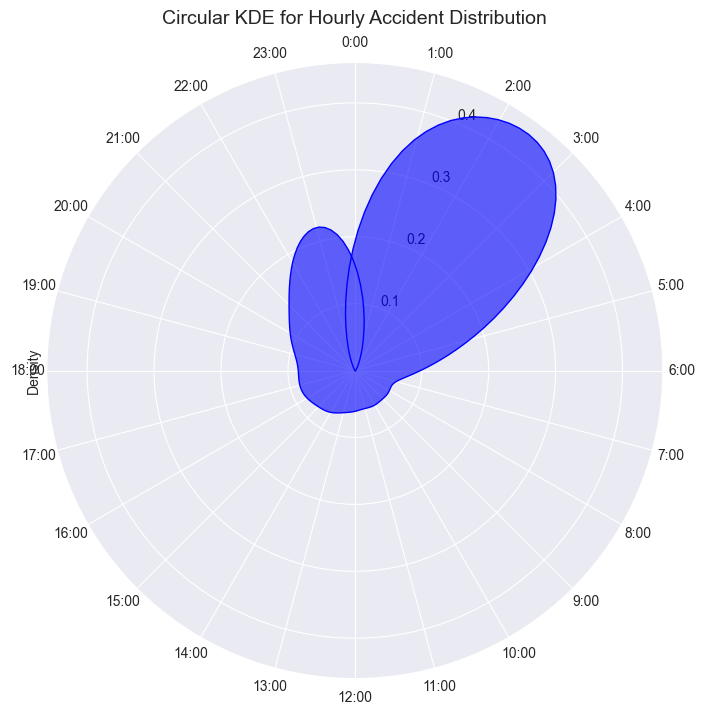

In [65]:
# Circular KDE Plot for Hourly Accident Distribution Based on Accident Data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Updated probabilities
hours = list(range(24))
normalized_scaled_array = [
    0.0950, 0.1154, 0.1248, 0.1047, 0.0564, 0.0275, 0.0177, 0.0152,
    0.0139, 0.0142, 0.0144, 0.0164, 0.0185, 0.0183, 0.0201, 0.0208,
    0.0212, 0.0217, 0.0224, 0.0256, 0.0324, 0.0387, 0.0542, 0.0906
]

# Generate hour values based on updated probabilities
hour_values = []
for hour, prob in zip(hours, normalized_scaled_array):
    size = int(prob * 1000)  # Scale to generate a proportional sample size
    hour_values.extend(np.random.uniform(low=hour, high=hour + 1, size=size))

# Convert hour values to angles for circular plot (24-hour cycle)
angles = np.deg2rad(np.array(hour_values) * 15)  # Convert hours to degrees (15° per hour)

# Create the circular KDE plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
sns.kdeplot(angles, bw_adjust=0.4, fill=True, alpha=0.6, ax=ax, color="blue")
ax.set_theta_direction(-1)  # Set clockwise direction
ax.set_theta_offset(np.pi / 2)  # Set 12 o'clock as the top

# Customize the plot
ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))  # Set hour labels
ax.set_xticklabels([f"{i}:00" for i in range(24)])  # Format hour labels
ax.set_title('Circular KDE for Hourly Accident Distribution', va='bottom', fontsize=14)

plt.show()

# Define and Smooth Accident Probability Distributions

This section defines discrete probability distributions for age, time of day, road type, and police unit based on historical accident data.
It uses interpolation and Kernel Density Estimation (KDE) to create smooth, continuous probability functions for age and time.
Additionally, it defines helper functions that return smoothed probabilities for each input parameter and combines them to compute the final accident probability with slight random noise for realism.


In [66]:
# Define the corrected probability distributions
age_group_probs = np.array([0.1929, 0.1692, 0.1428, 0.1265, 0.1177, 0.1160, 0.1349])
age_groups = np.array(['15-20', '21-24', '25-34', '35-44', '45-54', '55-64', '65+'])

road_type_probs = np.array([0.2645, 0.7355])  # Non-Urban, Urban
police_unit_probs = np.array([
    0.0515,
    0.0228,
    0.2867,
    0.1974,
    0.0351,
    0.0290,
    0.0371,
    0.0398,
    0.2228,
    0.0779
])
hour_probs = np.array([
    0.0950, 0.1154, 0.1248, 0.1047, 0.0564, 0.0275, 0.0177, 0.0152,
    0.0139, 0.0142, 0.0144, 0.0164, 0.0185, 0.0183, 0.0201, 0.0208,
    0.0212, 0.0217, 0.0224, 0.0256, 0.0324, 0.0387, 0.0542, 0.0906
]) # 0,1,2,...,23:00

# Smooth probabilities using interpolation
age_smooth = np.linspace(15, 100, 100)
hour_smooth = np.linspace(0, 23, 100)

age_interpolated_probs = np.interp(age_smooth, np.linspace(15, 80, len(age_group_probs)), age_group_probs)
hour_interpolated_probs = np.interp(hour_smooth, np.linspace(0, 23, len(hour_probs)), hour_probs)

# Normalize probabilities
age_interpolated_probs /= np.sum(age_interpolated_probs)
hour_interpolated_probs /= np.sum(hour_interpolated_probs)

# Fit a Kernel Density Estimation (KDE) for better probability smoothing
kde_age = gaussian_kde(age_smooth, weights=age_interpolated_probs)
print(age_interpolated_probs)
kde_hour = gaussian_kde(hour_smooth, weights=hour_interpolated_probs)
print(hour_interpolated_probs)

# Normalizing KDE outputs
age_pdf = kde_age(age_smooth)
hour_pdf = kde_hour(hour_smooth)

age_pdf /= np.sum(age_pdf)
hour_pdf /= np.sum(hour_pdf)

# Convert probabilities to continuous functions
def smooth_age_probability(age):
    """Returns a probability density estimate for age."""
    return np.interp(age, age_smooth, age_pdf)
#
# def smooth_hour_probability(hour):
#     """Returns a probability density estimate for time of day."""
#     return np.interp(hour, hour_smooth, hour_pdf)
#

# Incorporate sinusoidal transformation without distorting the original time distribution
def smooth_hour_probability_sin_corrected(time):
    """Returns a probability density estimate for time of day while preserving the original distribution."""
    # Convert time to a sinusoidal feature
    time_sin = np.sin(2 * np.pi * time / 24)
    time_cos = np.cos(2 * np.pi * time / 24)

    # Get the original probability estimate
    base_prob = np.interp(time, hour_smooth, hour_pdf)

    # Apply a small sinusoidal adjustment to retain the base distribution shape while ensuring smooth periodicity
    adjustment = 0.05 * (np.interp(time_sin, np.sin(2 * np.pi * hour_smooth / 24), hour_pdf) +
                          np.interp(time_cos, np.cos(2 * np.pi * hour_smooth / 24), hour_pdf))

    return base_prob + adjustment

def smooth_road_type_probability(road_type):
    """Returns a probability estimate for road type."""
    if road_type == "Urban":
        return road_type_probs[1]
    elif road_type == "Non-Urban":
        return road_type_probs[0]
    return np.mean(road_type_probs)  # Default to mean if road type is unknown

def smooth_police_unit_probability(police_unit_index):
    """Returns a probability estimate for police unit."""
    if 0 <= police_unit_index < len(police_unit_probs):
        return police_unit_probs[police_unit_index]
    return np.mean(police_unit_probs)  # Default to mean if index is out of range

def accident_probability(age, time, road_type, police_unit_index):
    """
    Computes the probability of an accident based on the given parameters using smoothed probabilities.
    Adds individual noise factors for each parameter for variability.

    Parameters:
    - age (int): Driver's age.
    - time (float): Fractional hour of the day.
    - road_type (str): Either "Urban" or "Non-Urban".
    - police_unit_index (int): Index representing the police unit.

    Returns:
    - Estimated probability of an accident.
    """
    # Get smoothed probabilities
    age_prob = smooth_age_probability(age)
    time_prob = smooth_hour_probability_sin_corrected(time)
    road_prob = smooth_road_type_probability(road_type)
    police_prob = smooth_police_unit_probability(police_unit_index)

    # Seed for reproducibility
    np.random.seed(42)

    # Generate individual noise factors
    age_noise = np.random.normal(loc=1.0, scale=0.1)      # Noise for age
    time_noise = np.random.normal(loc=1.0, scale=0.1)     # Noise for time
    road_noise = np.random.normal(loc=1.0, scale=0.1)     # Noise for road type
    police_noise = np.random.normal(loc=1.0, scale=0.1)   # Noise for police unit

    # Apply the noise to each parameter's probability
    age_prob *= age_noise
    time_prob *= time_noise
    road_prob *= road_noise
    police_prob *= police_noise

    # Compute the final accident probability
    accident_prob = age_prob * time_prob * road_prob * police_prob

    return accident_prob

[0.01392181 0.01378625 0.01365069 0.01351513 0.01337957 0.01324401
 0.01310845 0.01297289 0.01283733 0.01270177 0.01256621 0.01243064
 0.01229508 0.01215362 0.01200261 0.01185161 0.01170061 0.0115496
 0.0113986  0.01124759 0.01109659 0.01094559 0.01079458 0.01064358
 0.01049257 0.01034157 0.01023474 0.01014151 0.01004827 0.00995504
 0.00986181 0.00976857 0.00967534 0.00958211 0.00948887 0.00939564
 0.0093024  0.00920917 0.00912225 0.00907191 0.00902158 0.00897124
 0.00892091 0.00887057 0.00882024 0.0087699  0.00871957 0.00866923
 0.0086189  0.00856856 0.00851823 0.00848939 0.00847967 0.00846995
 0.00846022 0.0084505  0.00844078 0.00843105 0.00842133 0.0084116
 0.00840188 0.00839216 0.00838243 0.00837271 0.00847042 0.00857852
 0.00868663 0.00879473 0.00890284 0.00901094 0.00911905 0.00922716
 0.00933526 0.00944337 0.00955147 0.00965958 0.00973589 0.00973589
 0.00973589 0.00973589 0.00973589 0.00973589 0.00973589 0.00973589
 0.00973589 0.00973589 0.00973589 0.00973589 0.00973589 0.009735

# Visualization of Accident Probability Trends by Age and Time

This section generates test cases to visualize how accident probability varies as a function of driver age and time of day, separately for urban and non-urban environments.
Accident probabilities are computed across a range of ages (15 to 99) and hours of the day (0 to 23) using the previously defined probability model.
Two sets of visualizations are produced: (1) Accident probability as a function of age, comparing urban and non-urban scenarios and (2) Accident probability as a function of time of day under the same environmental settings.

Probability values are rescaled for improved visual interpretability, and plots include appropriate legends, titles, and gridlines to facilitate comparison.
This analysis enables a clear understanding of how risk patterns differ across demographic and temporal dimensions in varying road environments.


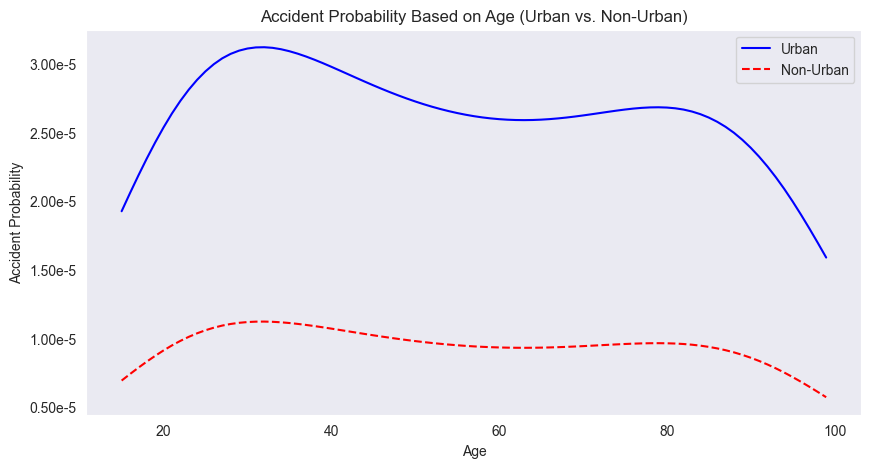

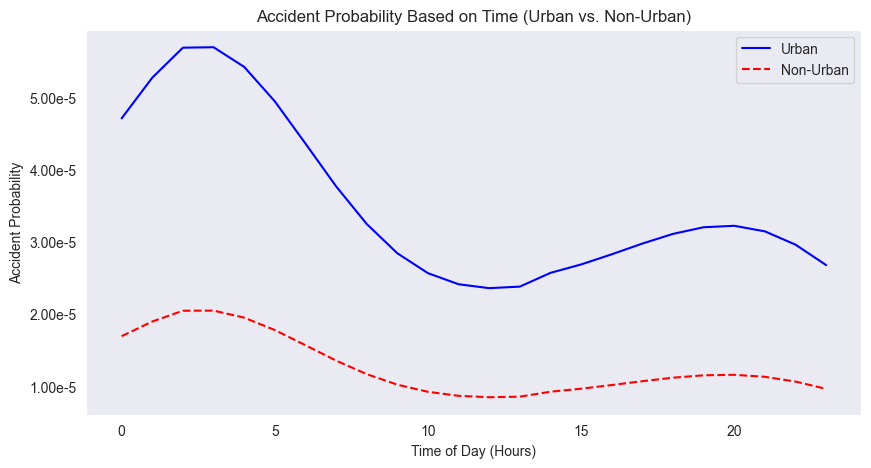

Total number of police units: 10


In [67]:

# Generate test cases for visualization
test_ages = np.arange(15, 100)
test_times = np.arange(0, 24, 1)

# Compute accident probabilities for age (Urban and Non-Urban)
age_probs_urban = [accident_probability(age, 18, "Urban", 2) for age in test_ages]
age_probs_non_urban = [accident_probability(age, 18, "Non-Urban", 2) for age in test_ages]

# Compute accident probabilities for time (Urban and Non-Urban)
time_probs_urban = [accident_probability(30, time, "Urban", 2) for time in test_times]
time_probs_non_urban = [accident_probability(30, time, "Non-Urban", 2) for time in test_times]

# Plot probability trends for Age (Urban vs. Non-Urban in the same graph)
plt.figure(figsize=(10, 5))
plt.plot(test_ages, age_probs_urban, label="Urban", linestyle='-', color='blue')
plt.plot(test_ages, age_probs_non_urban, label="Non-Urban", linestyle='--', color='red')
plt.xlabel("Age")
plt.ylabel("Accident Probability")
plt.title("Accident Probability Based on Age (Urban vs. Non-Urban)")
plt.legend()
plt.grid()

# Correct way to format Y-tick labels
formatter = ticker.FuncFormatter(lambda x, _: '{:.2f}e-5'.format(x / 1e-5))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

# Plot probability trends for Time (Urban vs. Non-Urban)
plt.figure(figsize=(10, 5))
plt.plot(test_times, time_probs_urban, label="Urban", linestyle='-', color='blue')
plt.plot(test_times, time_probs_non_urban, label="Non-Urban", linestyle='--', color='red')
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Accident Probability")
plt.title("Accident Probability Based on Time (Urban vs. Non-Urban)")
plt.legend()
plt.grid()

# Correct way to format Y-tick labels
formatter = ticker.FuncFormatter(lambda x, _: '{:.2f}e-5'.format(x / 1e-5))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()
# Print the total number of police units
num_police_units = len(police_unit_probs)
print(f"Total number of police units: {num_police_units}")


# Visualization of Regional Accident Probability Patterns

This section visualizes accident probability trends across different police unit areas.
Probabilities are computed over driver age and time of day under urban conditions, with each area distinctly labeled and color-coded.
The plots highlight regional differences in accident risk based on demographic and temporal factors.


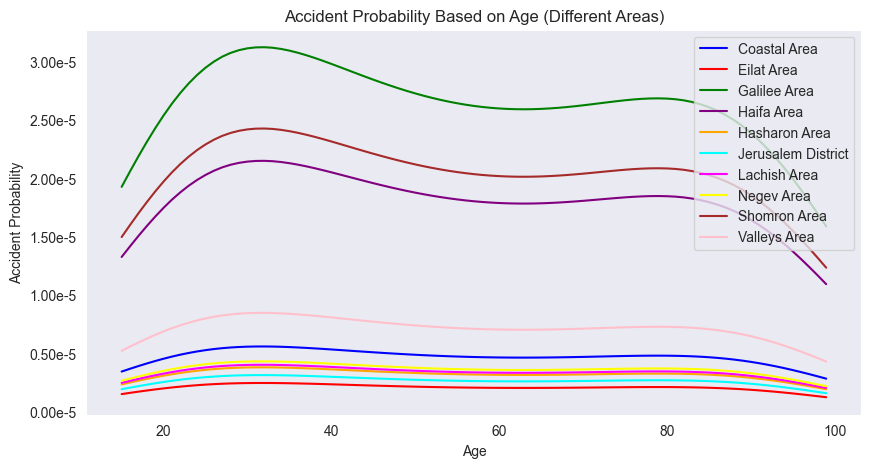

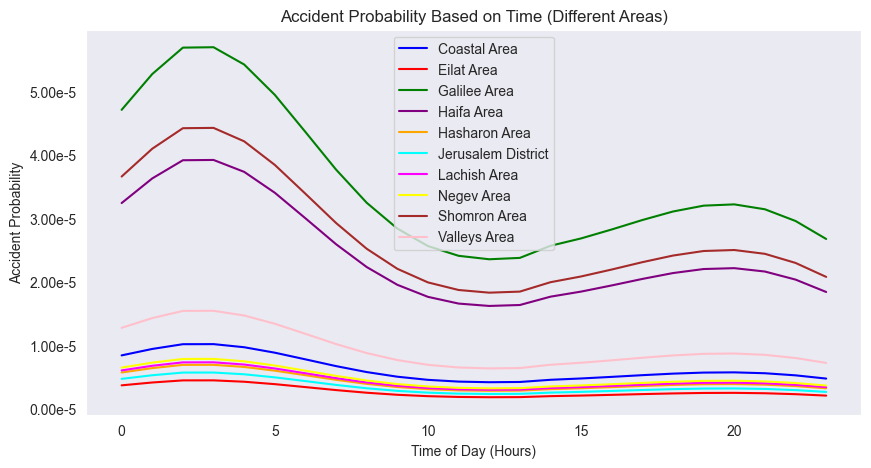

In [68]:

# Define mapping: Police Unit Index → Corresponding Area
area_categories = [
    "Coastal Area",
    "Eilat Area",
    "Galilee Area",
    "Haifa Area",
    "Hasharon Area",
    "Jerusalem District",
    "Lachish Area",
    "Negev Area",
    "Shomron Area",
    "Valleys Area"
]

# Ensure we are mapping correctly (10 police units)
police_units = list(range(10))  # 0 to 9

# Generate test cases for visualization
test_ages = np.arange(15, 100)
test_times = np.arange(0, 24, 1)

# Define 10 distinct colors for the areas (matching police units)
colors = [
    'blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta',
    'yellow', 'brown', 'pink'
]

# --- Plot probability trends for Age (Different Areas) ---
plt.figure(figsize=(10, 5))

for idx, police_unit in enumerate(police_units):
    area_name = area_categories[idx]
    age_probs = [accident_probability(age, 18, "Urban", police_unit) for age in test_ages]
    plt.plot(test_ages, age_probs, label=f"{area_name}", linestyle='-', color=colors[idx])

plt.xlabel("Age")
plt.ylabel("Accident Probability")
plt.title("Accident Probability Based on Age (Different Areas)")
plt.legend()
plt.grid()

# Format Y-ticks correctly
formatter = ticker.FuncFormatter(lambda x, _: '{:.2f}e-5'.format(x / 1e-5))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

# --- Plot probability trends for Time (Different Areas) ---
plt.figure(figsize=(10, 5))

for idx, police_unit in enumerate(police_units):
    area_name = area_categories[idx]
    time_probs = [accident_probability(30, time, "Urban", police_unit) for time in test_times]
    plt.plot(test_times, time_probs, label=f"{area_name}", linestyle='-', color=colors[idx])

plt.xlabel("Time of Day (Hours)")
plt.ylabel("Accident Probability")
plt.title("Accident Probability Based on Time (Different Areas)")
plt.legend()
plt.grid()

# Format Y-ticks correctly
formatter = ticker.FuncFormatter(lambda x, _: '{:.2f}e-5'.format(x / 1e-5))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()


# Logical Validation of the Accident Probability Function

This section defines and executes a basic unit test to validate the logical behavior of the `accident_probability` function.
Systematic variations are applied to each input parameter (time, age, road type, police unit) while holding others constant to ensure probability outputs remain within a valid range, vary appropriately with inputs, and produce consistent results for repeated calls.
Successful tests confirm the model’s internal consistency and expected responsiveness to key features.


In [69]:
def basic_test_accident_probability():
    """
    Runs a series of tests to validate that accident_probability behaves logically when
    changing each parameter (time, age, road type, police unit) while keeping others constant.
    """

    base_time = 12  # Noon
    base_age = 30
    base_road_type = "Urban"
    base_police_unit = 3  # Use the **index** instead of area name (e.g., "Coastal Area" → 3)

    # Get the base probability
    base_prob = accident_probability(base_age, base_time, base_road_type, base_police_unit)

    # --- 1. Check Effect of Time ---
    time_probs = []
    for time in range(0, 24, 3):  # Check every 3 hours
        time_probs.append(accident_probability(base_age, time, base_road_type, base_police_unit))

    assert min(time_probs) >= 0 and max(time_probs) <= 1, "Error: Time probability values out of range!"
    print("✅ Time variation produces probabilities in valid range.")

    assert time_probs[0] != time_probs[-1], "Error: Probability should change across different times!"
    print("✅ Probability changes across different times of day.")

    # --- 2. Check Effect of Age ---
    age_probs = []
    for age in range(18, 80, 10):  # Check every 10 years
        age_probs.append(accident_probability(age, base_time, base_road_type, base_police_unit))

    assert min(age_probs) >= 0 and max(age_probs) <= 1, "Error: Age probability values out of range!"
    print("✅ Age variation produces probabilities in valid range.")

    assert age_probs[0] != age_probs[-1], "Error: Probability should change for different ages!"
    print("✅ Probability changes with different ages.")

    # --- 3. Check Effect of Road Type ---
    road_types = ["Urban", "Non-Urban"]
    road_probs = {rt: accident_probability(base_age, base_time, rt, base_police_unit) for rt in road_types}

    assert all(0 <= p <= 1 for p in road_probs.values()), "Error: Road type probability out of range!"
    print("✅ Road type variation produces probabilities in valid range.")

    assert road_probs["Urban"] != road_probs["Non-Urban"], "Error: Probability should differ for road types!"
    print("✅ Probability differs between Urban and Non-Urban roads.")

    # --- 4. Check Effect of Police Unit ---
    police_units = list(range(10))  # Use indices (0-9) instead of area names
    police_probs = {pu: accident_probability(base_age, base_time, base_road_type, pu) for pu in police_units}

    assert all(0 <= p <= 1 for p in police_probs.values()), "Error: Police unit probability out of range!"
    print("✅ Police unit variation produces probabilities in valid range.")

    assert len(set(police_probs.values())) > 1, "Error: Probability should vary by police unit!"
    print("✅ Probability varies across different police units.")

    # --- 5. Check Consistency: Repeating the same call gives the same result ---
    repeated_prob = accident_probability(base_age, base_time, base_road_type, base_police_unit)
    assert base_prob == repeated_prob, "Error: Function is not deterministic for identical inputs!"
    print("✅ Function is deterministic (same input → same output).")

    print("\n🎉 All tests passed! The function behaves logically when changing parameters.")

# Run the test
basic_test_accident_probability()


✅ Time variation produces probabilities in valid range.
✅ Probability changes across different times of day.
✅ Age variation produces probabilities in valid range.
✅ Probability changes with different ages.
✅ Road type variation produces probabilities in valid range.
✅ Probability differs between Urban and Non-Urban roads.
✅ Police unit variation produces probabilities in valid range.
✅ Probability varies across different police units.
✅ Function is deterministic (same input → same output).

🎉 All tests passed! The function behaves logically when changing parameters.


# Generation of Synthetic Dataset Using KDE Sampling

This section generates a large synthetic dataset simulating driver characteristics and conditions relevant to accident risk modeling.
Age and time variables are sampled using Kernel Density Estimation (KDE) based on empirical distributions to ensure realistic variability.
Categorical features (area and road type) are randomly assigned according to observed proportions.
The final dataset, containing 300,000 records, is structured as a DataFrame and saved for subsequent modeling and analysis tasks.


In [70]:
# Constants
NUM_ROWS = 300000

# Area distributions
area_categories = ['Valleys Area', 'Negev Area', 'Hasharon Area', 'Coastal Area',
                   'Eilat Area', 'Lachish Area', 'Jerusalem District', 'Haifa Area',
                   'Galilee Area', 'Shomron Area']
area_proportions = [7.90, 7.61, 34.77, 13.09, 3.07, 7.88, 4.00, 8.49, 10.54, 2.65]
area_proportions = np.array(area_proportions) / sum(area_proportions)

# Road type distributions
road_types = ['Urban', 'Non-Urban']
road_type_proportions = [0.5693, 0.4307]

# Generate synthetic data for KDE
# Simulated Age Data (from distributions)
age_groups = {
    '17-18': (17, 18, 0.0035),
    '19-24': (19, 24, 0.0565),
    '25-34': (25, 34, 0.1274),
    '35-44': (35, 44, 0.1265),
    '45-54': (45, 54, 0.0983),
    '55-64': (55, 64, 0.0638),
    '65+': (65, 100, 0.0504)
}
age_data = []
for group, (min_age, max_age, prob) in age_groups.items():
    count = int(prob * NUM_ROWS)
    age_data.extend(np.random.randint(min_age, max_age + 1, size=count))

# Simulated Time Data (from hourly traffic distribution)
hours = list(range(24))
traffic_percentage = [0.5, 0.3, 0.2, 0.2, 0.4, 1.2, 3.0, 6.0, 7.0, 6.5, 6.5, 6.5, 6.5, 6.5,
                      6.5, 6.5, 6.5, 6.5, 6.0, 5.0, 3.5, 2.5, 1.5, 0.8]
time_proportions = np.array(traffic_percentage) / sum(traffic_percentage)
time_data = np.random.choice(hours, size=NUM_ROWS, p=time_proportions)

# KDE for Age
age_kde = gaussian_kde(age_data)
sampled_ages = age_kde.resample(NUM_ROWS).flatten()
sampled_ages = np.clip(sampled_ages, 17, 100).astype(int)  # Clip to realistic age bounds

# KDE for Time
time_kde = gaussian_kde(time_data)
sampled_times = time_kde.resample(NUM_ROWS).flatten()
sampled_times = np.clip(sampled_times, 0, 23).astype(int)  # Clip to 24-hour bounds

# Generate Time Strings
minute_choices = np.random.randint(0, 60, size=NUM_ROWS)
second_choices = np.random.randint(0, 60, size=NUM_ROWS)
sampled_time_strings = [f"{hour:02}:{minute:02}:{second:02}" for hour, minute, second in zip(sampled_times, minute_choices, second_choices)]

# IDs
ids = np.arange(1, NUM_ROWS + 1)

# Assign random areas and road types
area_choices = np.random.choice(area_categories, size=NUM_ROWS, p=area_proportions)
road_choices = np.random.choice(road_types, size=NUM_ROWS, p=road_type_proportions)

# Create the DataFrame
random_data = pd.DataFrame({
    "ID": ids,
    "Age": sampled_ages,  # KDE-based ages
    "Area": area_choices,
    "Road Type": road_choices,
    "Time": sampled_time_strings  # KDE-based times
})

# Save the random dataset
random_dataset_path = os.path.join(os.getcwd(), 'random_dataset.csv')
random_data.to_csv(random_dataset_path, index=False)

print(f"Random dataset saved to: {random_dataset_path}")

Random dataset saved to: /Users/sgahtan/Desktop/shira/studies/project/Project-RideShare/random_dataset.csv


# Threshold Analysis for Accident Classification

This section evaluates how different probability thresholds affect accident classification.
Accident probabilities are computed for each sample, and the number of predicted accident and non-accident cases is tracked across thresholds.
The results are visualized to guide optimal threshold selection.


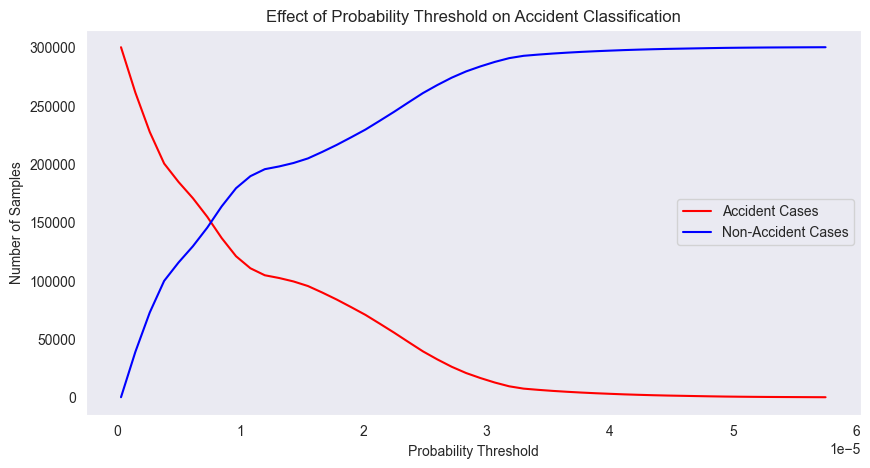

In [71]:
def analyze_thresholds(dataset_path):
    """
    Loads the dataset, applies accident_probability to each row,
    and finds an optimal threshold to classify accidents.
    """
    # Load dataset
    df = pd.read_csv(dataset_path)

    # Ensure necessary columns exist
    required_columns = ['Age', 'Time', 'Road Type', 'Area']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert time to fractional hours
    df['Time'] = df['Time'].apply(convert_time_to_decimal)

    # Map Area to Police Unit Index
    df['police_unit_index'] = df['Area'].map(area_to_police_unit)

    # Compute accident probabilities for each row
    df['predicted_prob'] = df.apply(lambda row: accident_probability(
        row['Age'], row['Time'], row['Road Type'], row['police_unit_index']
    ), axis=1)

    # Define probability thresholds to test
    thresholds = np.linspace(df['predicted_prob'].min(), df['predicted_prob'].max(), 50)

    # Store results
    results = []

    for threshold in thresholds:
        df['predicted_accident'] = df['predicted_prob'] > threshold

        # Count samples classified as accident vs. non-accident
        positive_cases = df['predicted_accident'].sum()
        negative_cases = len(df) - positive_cases

        results.append((threshold, positive_cases, negative_cases))

    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=['Threshold', 'Positive Cases', 'Negative Cases'])

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(results_df['Threshold'], results_df['Positive Cases'], label="Accident Cases", color='red')
    plt.plot(results_df['Threshold'], results_df['Negative Cases'], label="Non-Accident Cases", color='blue')
    plt.xlabel("Probability Threshold")
    plt.ylabel("Number of Samples")
    plt.title("Effect of Probability Threshold on Accident Classification")
    plt.legend()
    plt.grid()
    plt.show()

    return results_df
# Run analysis
results_df = analyze_thresholds(random_dataset_path)


# Threshold Sensitivity Analysis on Predicted Probabilities

This section applies the accident probability model to the dataset and examines how varying the classification threshold affects the number of predicted accident and non-accident cases.
Results are printed for a range of threshold values to support empirical selection of an appropriate decision boundary.


In [72]:
# Load the dataset
dataset_path =  '../Project-RideShare/random_dataset.csv'
df = pd.read_csv(dataset_path)

#print(df.head(2))

# Define mapping from Area to Police Unit Index
area_to_police_unit = {
    'Valleys Area': 0, 'Negev Area': 1, 'Hasharon Area': 2, 'Coastal Area': 3,
    'Eilat Area': 4, 'Lachish Area': 5, 'Jerusalem District': 6, 'Haifa Area': 7,
    'Galilee Area': 8, 'Shomron Area': 9
}

# Convert time to fractional hours
def convert_time_to_decimal(time_str):
    """Converts HH:MM:SS time format to fractional hours."""
    h, m, s = map(int, time_str.split(":"))
    return h + m / 60 + s / 3600

df['Time'] = df['Time'].apply(convert_time_to_decimal)
df['police_unit_index'] = df['Area'].map(area_to_police_unit)

# Compute accident probabilities for each row using accident_probability function
df['predicted_prob'] = df.apply(lambda row: accident_probability(
    row['Age'], row['Time'], row['Road Type'], row['police_unit_index']
), axis=1)

# Define a range of thresholds (1e-5 to 3e-5)
thresholds = np.linspace(0.2e-5, 5e-5, 20)

# Try different thresholds and print results
for threshold in thresholds:
    positive_cases = (df['predicted_prob'] > threshold).sum()
    negative_cases = len(df) - positive_cases

    print(f"Threshold: {threshold:.6e} → Positive: {positive_cases}, Negative: {negative_cases}")


Threshold: 2.000000e-06 → Positive: 245488, Negative: 54512
Threshold: 4.526316e-06 → Positive: 189499, Negative: 110501
Threshold: 7.052632e-06 → Positive: 158993, Negative: 141007
Threshold: 9.578947e-06 → Positive: 121814, Negative: 178186
Threshold: 1.210526e-05 → Positive: 104260, Negative: 195740
Threshold: 1.463158e-05 → Positive: 98329, Negative: 201671
Threshold: 1.715789e-05 → Positive: 87195, Negative: 212805
Threshold: 1.968421e-05 → Positive: 73824, Negative: 226176
Threshold: 2.221053e-05 → Positive: 57115, Negative: 242885
Threshold: 2.473684e-05 → Positive: 39943, Negative: 260057
Threshold: 2.726316e-05 → Positive: 25604, Negative: 274396
Threshold: 2.978947e-05 → Positive: 15418, Negative: 284582
Threshold: 3.231579e-05 → Positive: 8096, Negative: 291904
Threshold: 3.484211e-05 → Positive: 5830, Negative: 294170
Threshold: 3.736842e-05 → Positive: 4156, Negative: 295844
Threshold: 3.989474e-05 → Positive: 2955, Negative: 297045
Threshold: 4.242105e-05 → Positive: 2043

# Labeling the Dataset Based on Accident Probability Threshold

This section computes accident probabilities for each record and assigns binary accident labels based on a selected probability threshold.
The updated dataset, including the new accident indicator, is saved for future modeling and evaluation.



In [73]:
# Load the dataset
dataset_path = os.path.join(os.getcwd(), 'random_dataset.csv')
df = pd.read_csv(dataset_path)

# Define mapping from Area to Police Unit Index
area_to_police_unit = {
    'Valleys Area': 0, 'Negev Area': 1, 'Hasharon Area': 2, 'Coastal Area': 3,
    'Eilat Area': 4, 'Lachish Area': 5, 'Jerusalem District': 6, 'Haifa Area': 7,
    'Galilee Area': 8, 'Shomron Area': 9
}

df['Time'] = df['Time'].apply(convert_time_to_decimal)
df['police_unit_index'] = df['Area'].map(area_to_police_unit)

# Compute accident probabilities for each row using accident_probability function
df['predicted_prob'] = df.apply(lambda row: accident_probability(
    row['Age'], row['Time'], row['Road Type'], row['police_unit_index']
), axis=1)

# Choose a threshold for accident occurrence
# This can be adjusted based on the distribution of predicted probabilities
threshold = 2.555556e-05

# Add a column indicating whether an accident occurred
df['Accident'] = (df['predicted_prob'] > threshold).astype(int)

# Construct a relative path to the CSV file
output_file_path = os.path.join(os.getcwd(), 'random_dataset_with_accidents.csv')

# Save the DataFrame to the CSV file using the relative path
df.to_csv(output_file_path, index=False)

# Display the first few rows of the updated dataset
print(df.head())
# Calculate and print the number of accidents tagged as positive
positive_accidents = df['Accident'].sum()

print(f"Number of accidents tagged as positive: {positive_accidents}")


   ID  Age           Area  Road Type       Time  police_unit_index  \
0   1   29  Hasharon Area  Non-Urban  11.913056                  2   
1   2   23   Valleys Area      Urban   5.417778                  0   
2   3   18   Coastal Area  Non-Urban   6.637500                  3   
3   4   48   Valleys Area      Urban   6.263056                  0   
4   5   47  Hasharon Area  Non-Urban   3.461667                  2   

   predicted_prob  Accident  
0        0.000008         0  
1        0.000008         0  
2        0.000007         0  
3        0.000007         0  
4        0.000018         0  
Number of accidents tagged as positive: 34787


# Decision Tree Modeling and Evaluation

This section applies a decision tree classifier to predict accident occurrence based on driver and environmental features.
Categorical variables are encoded numerically, and the data is split into training and testing subsets.
Hyperparameter tuning is performed using GridSearchCV to optimize model performance.
The final model is evaluated using standard classification metrics, and the resulting decision tree is visualized to interpret decision boundaries.


Confusion Matrix:
 [[78491  1058]
 [  313 10138]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     79549
           1       0.91      0.97      0.94     10451

    accuracy                           0.98     90000
   macro avg       0.95      0.98      0.96     90000
weighted avg       0.99      0.98      0.98     90000



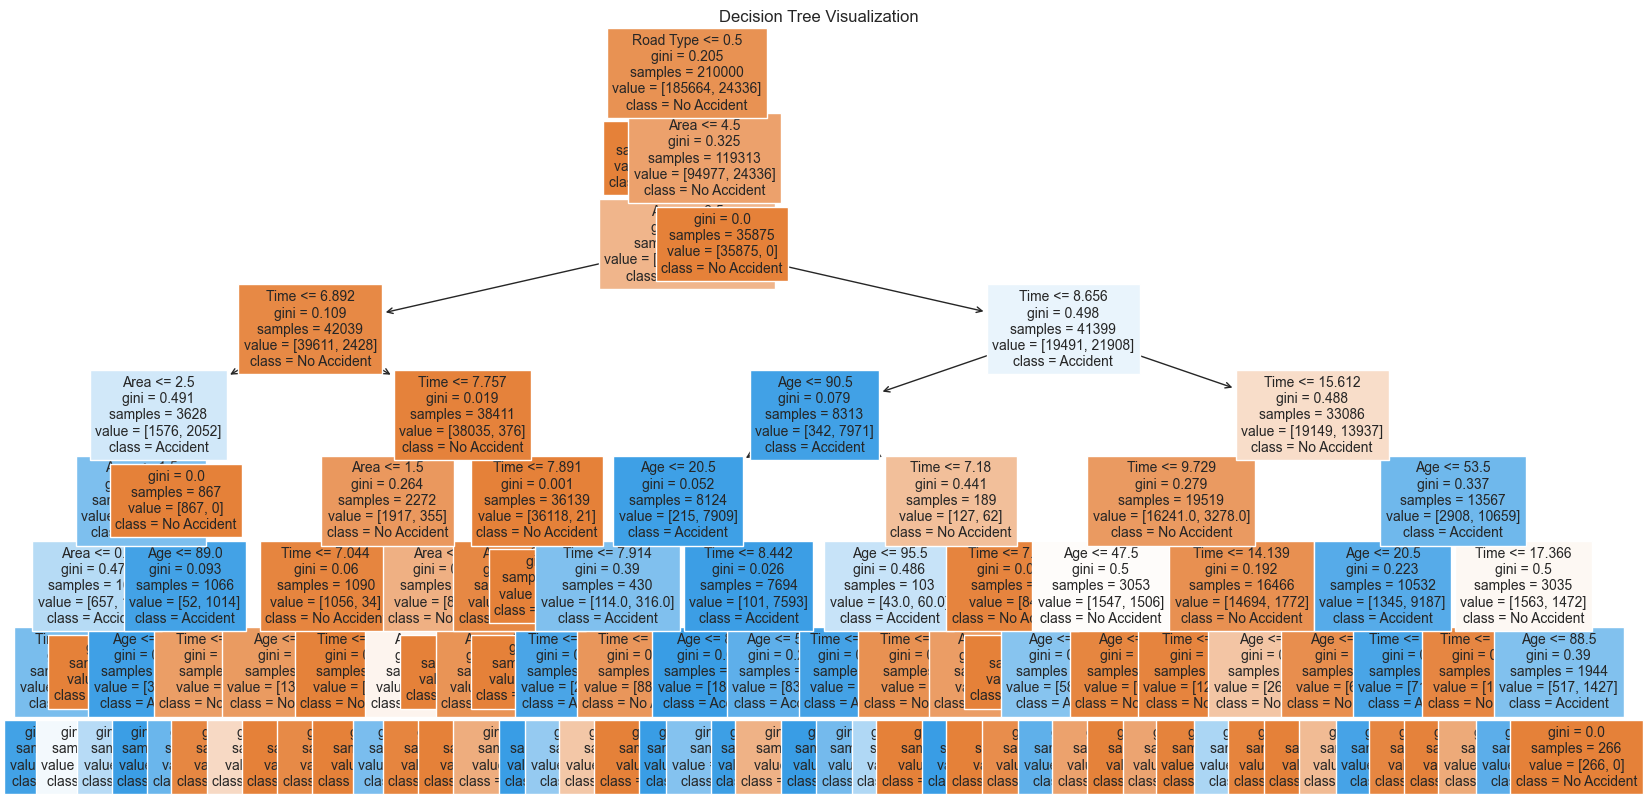

In [74]:
# Load the dataset
df = pd.read_csv('../Project-RideShare/random_dataset_with_accidents.csv')

# Data Preprocessing
# Convert categorical features into numerical
categorical_features = ['Area', 'Road Type']
for col in categorical_features:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

# Define features (X) and target (y)
X = df[['Age', 'Area', 'Road Type', 'Time']]
y = df['Accident']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter Tuning using GridSearchCV (Other combinations can be checked)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [ 3,5,8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy')  # Using accuracy as the scoring metric

grid_search.fit(X_train, y_train)

# Get the best estimator
best_tree = grid_search.best_estimator_

# Evaluate the model
y_pred = best_tree.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree,
          feature_names=X.columns,
          class_names=['No Accident', 'Accident'],
          filled=True,
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

# Comparative Analysis of Threshold Impacts on Model Performance

Building on the previous decision tree modeling, this section systematically evaluates how varying the probability threshold for labeling accidents affects dataset balance, model training, and predictive performance.
For each selected threshold, a new dataset is generated, a decision tree is trained with hyperparameter tuning, and evaluation metrics are reported.
This analysis provides insights into the sensitivity of model outcomes to threshold selection and helps identify thresholds that optimize classification effectiveness.



Running with threshold: 4.242105e-05
Number of accidents tagged as positive: 2043
Confusion Matrix:
 [[89307    67]
 [  178   448]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     89374
           1       0.87      0.72      0.79       626

    accuracy                           1.00     90000
   macro avg       0.93      0.86      0.89     90000
weighted avg       1.00      1.00      1.00     90000



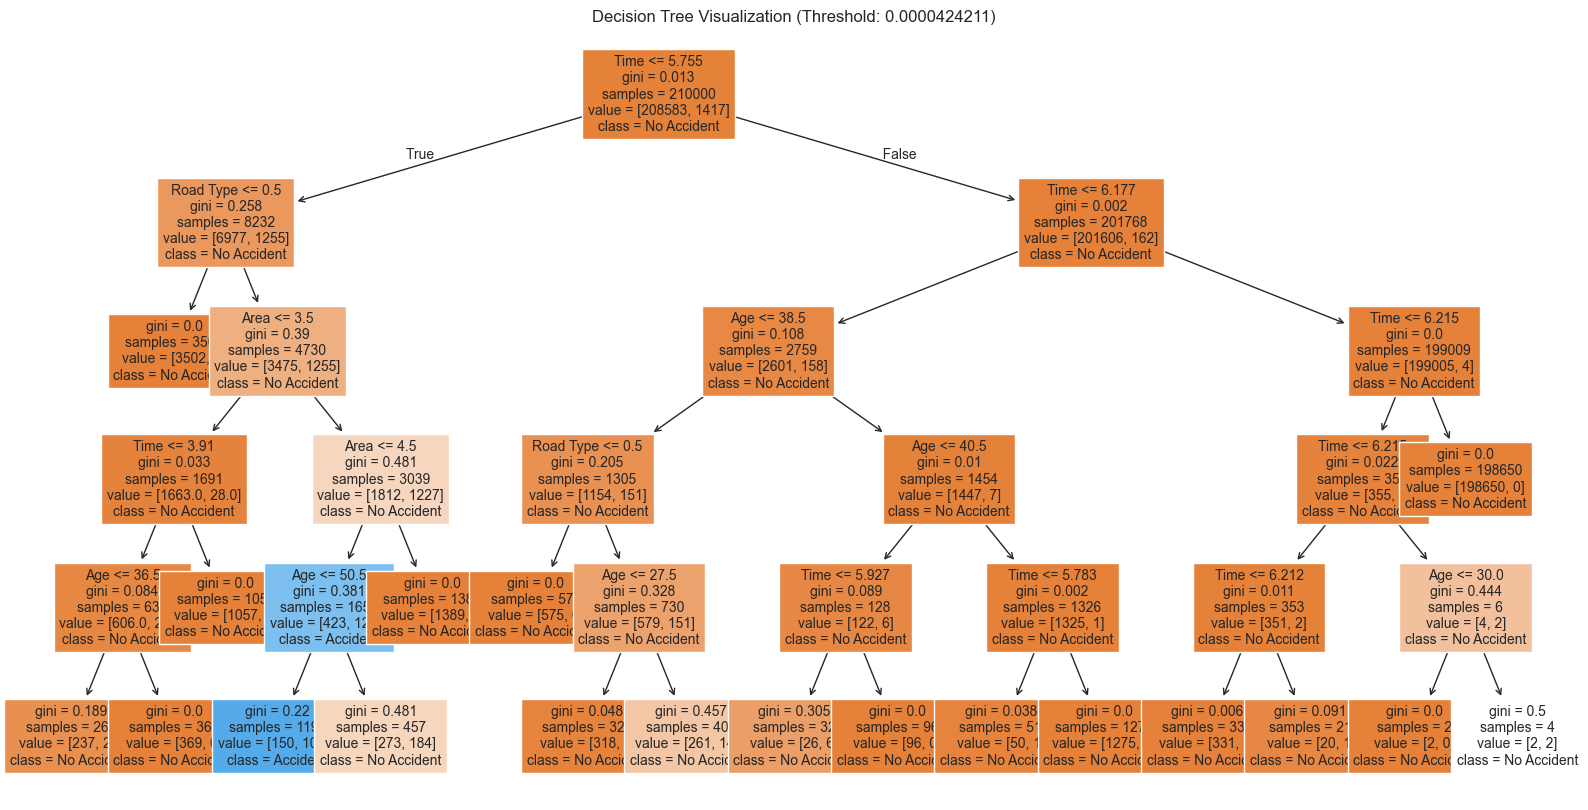


Running with threshold: 1.888889e-05
Number of accidents tagged as positive: 77792
Confusion Matrix:
 [[65823   778]
 [ 3738 19661]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     66601
           1       0.96      0.84      0.90     23399

    accuracy                           0.95     90000
   macro avg       0.95      0.91      0.93     90000
weighted avg       0.95      0.95      0.95     90000



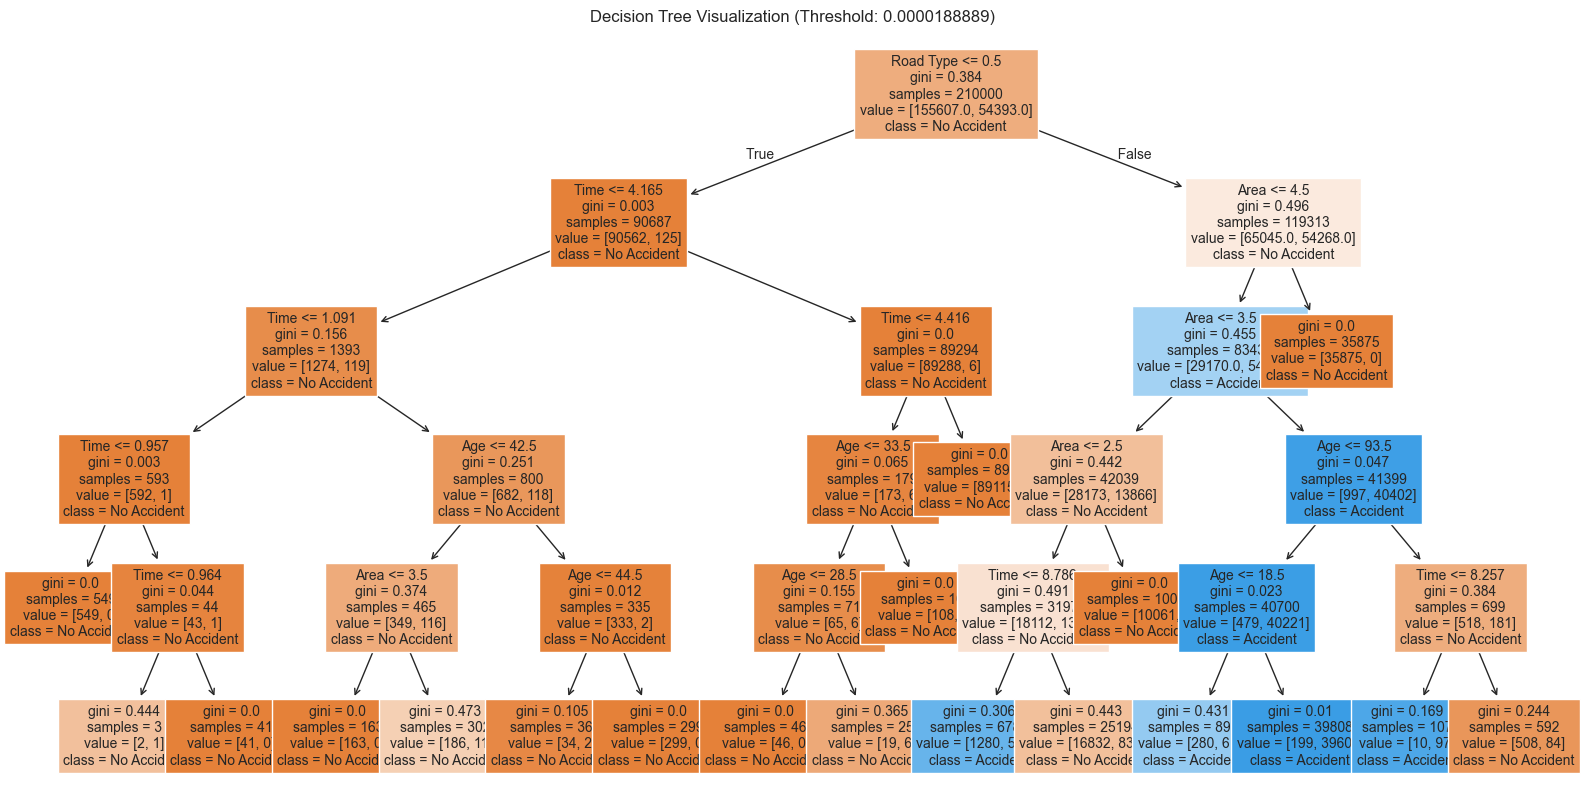


Running with threshold: 1e-05
Number of accidents tagged as positive: 117203
Confusion Matrix:
 [[50833  3917]
 [  724 34526]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     54750
           1       0.90      0.98      0.94     35250

    accuracy                           0.95     90000
   macro avg       0.94      0.95      0.95     90000
weighted avg       0.95      0.95      0.95     90000



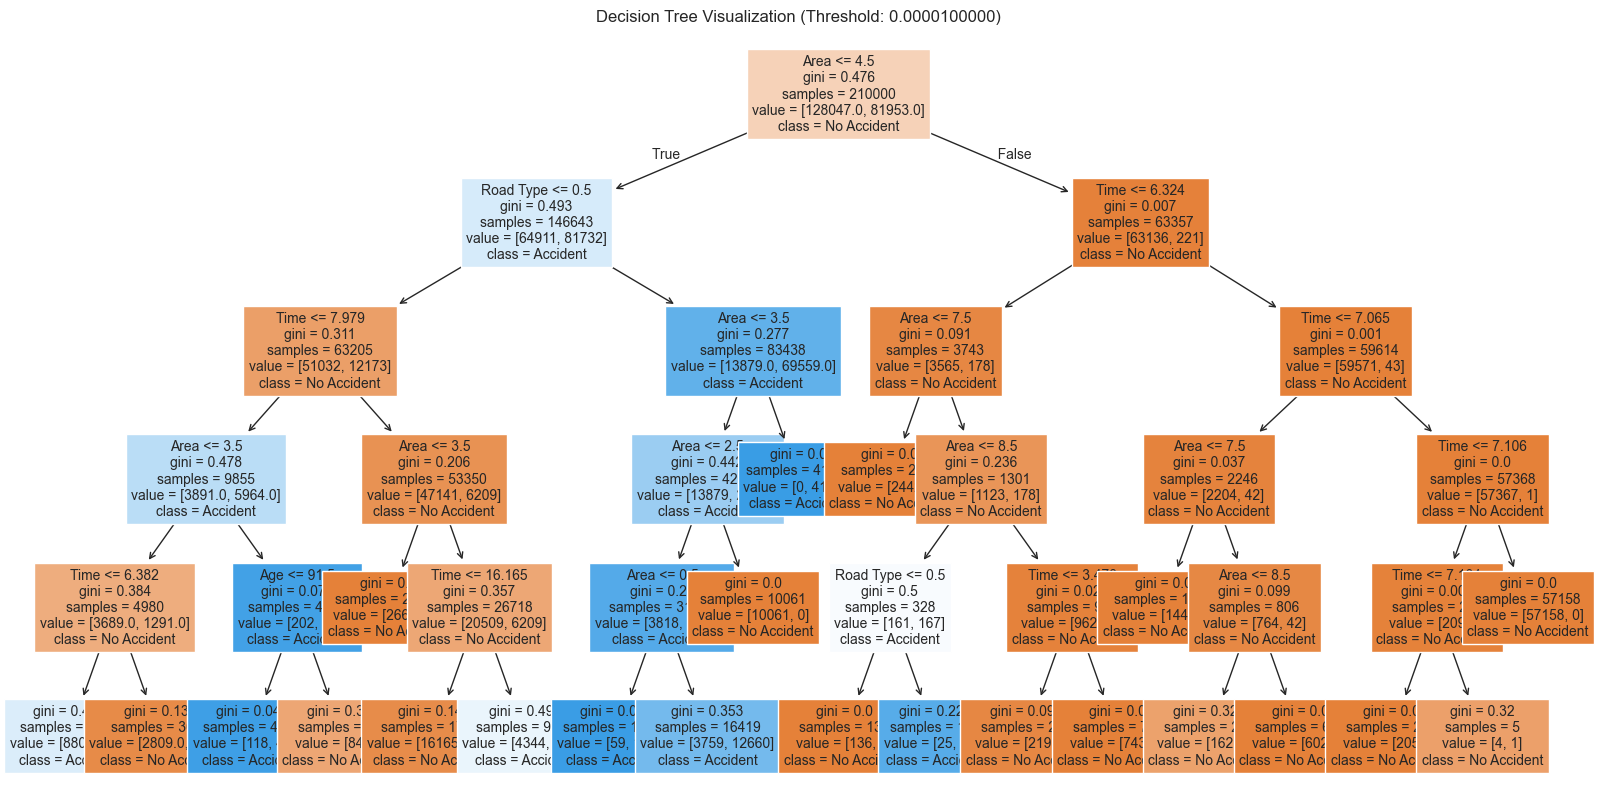

In [75]:


# Define threshold values
threshold_values = [4.242105e-05, 1.888889e-05, 1.000000e-05]

# Load the dataset
dataset_path = os.path.join(os.getcwd(), 'random_dataset.csv')
df = pd.read_csv(dataset_path)

# Define mapping from Area to Police Unit Index
area_to_police_unit = {
    'Valleys Area': 0, 'Negev Area': 1, 'Hasharon Area': 2, 'Coastal Area': 3,
    'Eilat Area': 4, 'Lachish Area': 5, 'Jerusalem District': 6, 'Haifa Area': 7,
    'Galilee Area': 8, 'Shomron Area': 9
}

df['Time'] = df['Time'].apply(convert_time_to_decimal)
df['police_unit_index'] = df['Area'].map(area_to_police_unit)

# Iterate over each threshold
for threshold in threshold_values:
    print(f"\nRunning with threshold: {threshold}")

    # Compute accident probabilities
    df['predicted_prob'] = df.apply(lambda row: accident_probability(
        row['Age'], row['Time'], row['Road Type'], row['police_unit_index']
    ), axis=1)

    # Assign accidents based on threshold
    df['Accident'] = (df['predicted_prob'] > threshold).astype(int)

    # Print number of positive accidents
    positive_accidents = df['Accident'].sum()
    print(f"Number of accidents tagged as positive: {positive_accidents}")

    # Save dataset with threshold in filename
    output_file = os.path.join(os.getcwd(), f'random_dataset_with_accidents_{threshold:.10f}.csv')
    df.to_csv(output_file, index=False)

    # Train and evaluate Decision Tree model
    # Load the modified dataset
    df_model = pd.read_csv(output_file)

    # Convert categorical features into numerical
    categorical_features = ['Area', 'Road Type']
    for col in categorical_features:
        df_model[col] = df_model[col].astype('category').cat.codes

    # Define features (X) and target (y)
    X = df_model[['Age', 'Area', 'Road Type', 'Time']]
    y = df_model['Accident']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5]
    }

    grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid,
                               cv=5,
                               scoring='accuracy')

    grid_search.fit(X_train, y_train)

    # Get the best model
    best_tree = grid_search.best_estimator_

    # Evaluate the model
    y_pred = best_tree.predict(X_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Visualize the Decision Tree
    plt.figure(figsize=(20, 10))
    plot_tree(best_tree,
              feature_names=X.columns,
              class_names=['No Accident', 'Accident'],
              filled=True,
              fontsize=10)
    plt.title(f"Decision Tree Visualization (Threshold: {threshold:.10f})")
    plt.show()


# Baseline and Advanced Classification Modeling: Logistic Regression and SVM

This section establishes a baseline accident prediction model using logistic regression and further develops an advanced model using a Support Vector Machine (SVM) with an RBF kernel.
Data preprocessing includes categorical encoding, standardization, and train-test splitting.
To address class imbalance, random undersampling is applied before SVM training.
Model performance is evaluated using accuracy and detailed classification metrics, with threshold adjustment employed to optimize precision.


In [76]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv('../Project-RideShare/random_dataset_with_accidents.csv')
df = df.sample(frac=1.0, random_state=42)

# Encode categorical features
categorical_features = ['Area', 'Road Type']
print("Encoding categorical features...")
for col in tqdm(categorical_features, desc="Encoding"):
    df[col] = pd.Categorical(df[col]).codes

# Features and labels
X = df[['Age', 'Area', 'Road Type', 'Time']].values
y = df['Accident'].values

# Standardize
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
print(" Splitting train/test data...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# === Baseline Model ===
print("\nTraining Baseline: Logistic Regression")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_baseline = log_reg.predict(X_test)

print("Baseline Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))

#print("\n🚩 Training SVC (RBF Kernel) with Undersampling and class_weight='balanced'")

with tqdm(total=4, desc="SVM Training Pipeline") as pbar:
    # Step 1: Undersample
    undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
    pbar.update(1)

    # Step 2: Train with SVC
    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        probability=True,  # Allows future thresholding
        random_state=42
    )
    svm_model.fit(X_resampled, y_resampled)
    pbar.update(1)

   # Get predicted probabilities
    y_probs = svm_model.predict_proba(X_test)[:, 1]  # probability for class 1

    # Adjust threshold to increase precision
    threshold = 0.8  # 0.6, 0.7, 0.8...
    y_pred_adjusted = (y_probs >= threshold).astype(int)

    # Evaluate
    print(f" Adjusted Threshold Results (threshold = {threshold}):")
    print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
    print(classification_report(y_test, y_pred_adjusted))
    pbar.update(1)

Loading dataset...
Encoding categorical features...


Encoding: 100%|██████████| 2/2 [00:00<00:00, 93.53it/s]

Scaling features...
 Splitting train/test data...

Training Baseline: Logistic Regression
Baseline Results:
Accuracy: 0.8824555555555555



/Users/sgahtan/Desktop/shira/studies/project/Project-RideShare/#/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sgahtan/Desktop/shira/studies/project/Project-RideShare/#/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sgahtan/Desktop/shira/studies/project/Project-RideShare/#/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     79421
           1       0.00      0.00      0.00     10579

    accuracy                           0.88     90000
   macro avg       0.44      0.50      0.47     90000
weighted avg       0.78      0.88      0.83     90000



SVM Training Pipeline:  75%|███████▌  | 3/4 [00:53<00:17, 17.95s/it]

 Adjusted Threshold Results (threshold = 0.8):
Accuracy: 0.9701444444444445
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     79421
           1       0.88      0.86      0.87     10579

    accuracy                           0.97     90000
   macro avg       0.93      0.92      0.93     90000
weighted avg       0.97      0.97      0.97     90000

